# UNET SEGMENTATION

Arxiv Link: <a href="https://arxiv.org/abs/1505.04597">U-Net: Convolutional Networks for Biomedical Image Segmentation</a>

<ul>
<li>UNet is a fully convolutional network(FCN) that does image segmentation. Its goal is to predict each pixel's class.</li>
 
<li>UNet is built upon the FCN and modified in a way that it yields better segmentation in medical imaging.</li>
</ul>

## 1.1 Architecture

<img src="images/u-net-architecture.png"/>

<h3>UNet Architecture has 3 parts:</h3>
<ol>
    <li>The Contracting/Downsampling Path</li>
    <li>Bottleneck</li>
    <li>The Expanding/Upsampling Path</li>
</ol>

<h3>Downsampling Path: </h3> 
<ol>
    <li>It consists of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling.</li> 
    <li>At each downsampling step we double the number of feature channels.</li>
</ol>

<h3>Upsampling Path: </h3> 
<ol>
     <li> Every  step  in  the  expansive  path  consists  of  an  upsampling  of  the feature map followed by a 2x2 convolution (“up-convolution”), a concatenation with the correspondingly feature  map  from  the  downsampling  path,  and  two  3x3  convolutions,  each  followed by a ReLU.</li>
</ol>

<h3> Skip Connection: </h3>
The skip connection from the downsampling path are concatenated with feature map during upsampling path. These skip connection provide local information to global information while upsampling.

<h3> Final Layer: </h3>
At the final layer a 1x1 convolution is used to map each feature vector to the desired number of classes.

## 1.2 Advantages
<h3> Advantages: </h3>
<ol>
    <li>The UNet combines the location information from the downsampling path to finally obtain a general information combining localisation and context, which is necessary to predict a good segmentation map.</li>
    <li>No Dense layer is used, so image sizes can be used.</li>
</ol>

## 1.3 Dataset
Link: <a href="https://www.kaggle.com/c/data-science-bowl-2018">Data Science Bowl 2018</a>
Find the nuclei in divergent images to advance medical discovery

## 1.4 Code

In [58]:
## Imports
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import skimage
from skimage import transform
from skimage import util
from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import imageio
## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

## Data Generator

In [60]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)
        
        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = np.zeros((self.image_size, self.image_size, 1))
        
        ## Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)
            
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        batch_size_ = self.batch_size - 1
        if(index+1)*batch_size_ >= len(self.ids):
            batch_size_ = len(self.ids) - batch_size_
        
        files_batch = self.ids[index*batch_size_ : (index+1)*batch_size_]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        image = image.astype(np.float32)
        image, mask = make_aug(image, mask)
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [62]:
def make_aug_seg(images, masks):
    seq = iaa.Sequential([
        iaa.Dropout([0.3, 0.5]),
        iaa.Sharpen((0.0,1.0))
    ], random_order = True)

    for _ in range(1):
        i = random.randint(0, len(images)-1)
        print("REAL:")
        print("image:")
        plt.imshow(images[i])
        plt.show()
        print("/REAL")
        images_aug_i = seq(image=images[i])    
        #images = np.append(images,images_aug_i)
        #masks = np.append(masks,masks[i])
        images = np.insert(images, 0, images_aug_i,  axis=0)
        masks = np.insert(masks, 0, masks[i],  axis=0)
        print("AUGMENTED:")
        plt.imshow(images_aug_i)
        plt.show()
        print("/AUGMENTED")
    return images, masks

    

In [64]:
def make_aug(images, masks):
    seq = iaa.Sequential([
        #iaa.Affine(rotate=(-45, 45)),
        iaa.ElasticTransformation(alpha=50, sigma=5)
    ], random_order = True)

    for _ in range(1):
        i = random.randint(0, len(images)-1)
        int_mask = (masks[i]).astype(np.uint8)
        segmap = SegmentationMapsOnImage(int_mask, shape=masks[i].shape)
        images_aug_i, segmaps_aug_i = seq(image=images[i], segmentation_maps = segmap)    
        #images = np.append(images,images_aug_i)
        #masks = np.append(masks,masks[i])
        mask_ = segmaps_aug_i.draw(size = (128,128,1))


        mask_ = np.asarray(mask_)[0]
        mask_ = mask_[:,:,0]
        mask_ = (masks[i]).astype(np.uint8)
        mask_ = np.reshape(mask_, (image_size, image_size,1))
        images = np.insert(images, 0, images_aug_i,  axis=0)
        masks = np.insert(masks, 0, mask_,  axis=0)
    return images, masks


## Hyperparameters

In [66]:
image_size = 128
train_path = "../unet/dataset/stage1_train/"
epochs = 8
batch_size = 8

## Training Ids
train_ids = next(os.walk(train_path))[1]

## Validation Data Size
val_data_size = 10

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [68]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)


(8, 128, 128, 3) (8, 128, 128, 1)


W0919 23:34:19.936511 23908 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


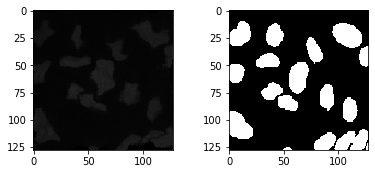

In [69]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

## Different Convolutional Blocks

In [70]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

## UNet Model

In [71]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [72]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_114 (Conv2D)             (None, 128, 128, 16) 448         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 128, 128, 16) 2320        conv2d_114[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 64, 64, 16)   0           conv2d_115[0][0]                 
____________________________________________________________________________________________

## Training the model

In [73]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//(batch_size-1)
valid_steps = len(valid_ids)//(batch_size-1)
model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=8)

Epoch 1/8
94/94 [==============================] - 181s 2s/step - loss: 0.4496 - acc: 0.8368 - val_loss: 0.2790 - val_acc: 0.8330
Epoch 2/8
94/94 [==============================] - 185s 2s/step - loss: 0.1893 - acc: 0.9029 - val_loss: 0.2536 - val_acc: 0.8865
Epoch 3/8
94/94 [==============================] - 173s 2s/step - loss: 0.1388 - acc: 0.9316 - val_loss: 0.1729 - val_acc: 0.9181
Epoch 4/8
94/94 [==============================] - 171s 2s/step - loss: 0.1249 - acc: 0.9385 - val_loss: 0.1357 - val_acc: 0.9252
Epoch 5/8
94/94 [==============================] - 155s 2s/step - loss: 0.1286 - acc: 0.9370 - val_loss: 0.1407 - val_acc: 0.9271
Epoch 6/8
94/94 [==============================] - 152s 2s/step - loss: 0.1158 - acc: 0.9427 - val_loss: 0.1386 - val_acc: 0.9261
Epoch 7/8
94/94 [==============================] - 148s 2s/step - loss: 0.1054 - acc: 0.9460 - val_loss: 0.1473 - val_acc: 0.9223
Epoch 8/8
94/94 [==============================] - 178s 2s/step - loss: 0.1048 - acc: 0.94

## Testing the model

In [ ]:
## Save the Weights
model.save_weights("UNetW.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.5

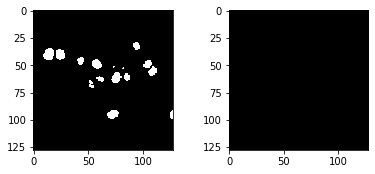

In [23]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

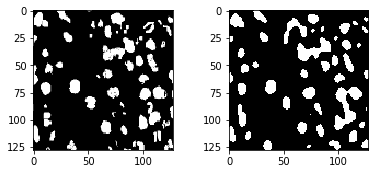

In [24]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")